In [12]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36025 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43583 Dashboard: http://127.0.0.1:36025/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [13]:
import numpy as np
import xarray as xr
import qgutils
from xgcm.grid import Grid
import os.path as op
import gcm_filters
# import dask_image.ndfilters as ndfilters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
ddir = '/store/tuchida/msom/msqg/stochas/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/stochas/'

In [15]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*2    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
# ntime = 187

In [16]:
dsbp = xr.open_zarr(op.join(ddir,'Mean-Eddy0002'))
dsjac = xr.open_zarr(op.join(ddir,'JacPsipQp0002/'))
dsbp

<xarray.Dataset>
Dimensions:  (XC: 512, YC: 512, Z: 3, time: 4977)
Coordinates:
  * XC       (XC) float64 0.07812 0.2344 0.3906 0.5469 ... 79.61 79.77 79.92
  * YC       (YC) float64 0.07812 0.2344 0.3906 0.5469 ... 79.61 79.77 79.92
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
Data variables:
    pb       (Z, YC, XC) float32 dask.array<chunksize=(3, 128, 128), meta=np.ndarray>
    psip     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    qb       (Z, YC, XC) float32 dask.array<chunksize=(3, 128, 128), meta=np.ndarray>
    qp       (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

<xarray.DataArray 'pb' (YC: 128, XC: 128)>
dask.array<dask_aware_interpnd, shape=(128, 128), dtype=float32, chunksize=(128, 128), chunktype=numpy.ndarray>
Coordinates:
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69


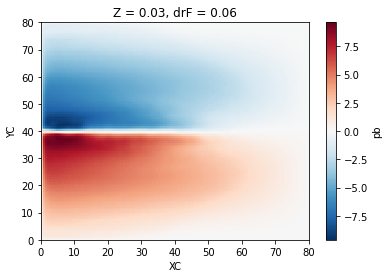

In [16]:
print(dsbp.pb.isel(Z=0).interp({'YC':np.arange(dx*2,L0,dx*4),'XC':np.arange(dx*2,L0,dx*4)}))
dsbp.pb.isel(Z=0).coarsen(YC=nmask, XC=nmask, boundary='exact').mean().plot()

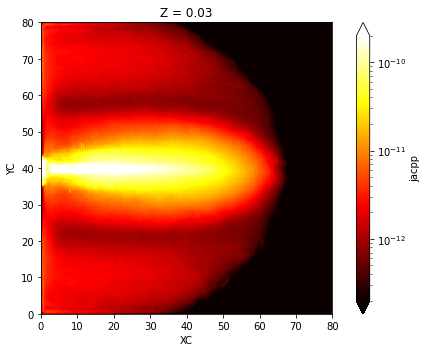

In [17]:
jacstd = dsjac.jacpp.std('time').compute()

fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
(jacstd.isel(Z=0) * U**2/Rd**2).plot(cmap='hot', norm=clr.LogNorm(vmin=2e-13, vmax=2e-10))
ax.set_aspect('equal', adjustable='box')

In [18]:
jacstd_padded = xr.DataArray(np.zeros((3,N+2,N+2)), dims=['Z','Yp1','Xp1'],
                             coords={'Z':jacstd.Z.data, 'Yp1':np.arange(-dx/2,L0+dx,dx),
                                     'Xp1':np.arange(-dx/2,L0+dx,dx)}
                            )
mask = xr.DataArray(np.zeros((3,N+2,N+2)), dims=['Z','Yp1','Xp1'],
                    coords={'Z':jacstd.Z.data, 'Yp1':np.arange(-dx/2,L0+dx,dx),
                            'Xp1':np.arange(-dx/2,L0+dx,dx)}
                   )
mask.isel(Yp1=slice(1,-1),Xp1=slice(1,-1))[:] = 1
jacstd_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1))[:] = jacstd
jacstd_padded = jacstd_padded.where(jacstd_padded>0.)
jacstd_padded

<xarray.DataArray (Z: 3, Yp1: 514, Xp1: 514)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 7.21989479e-03, 3.86760831e-02, ...,
         7.75790773e-04, 4.15570668e-07,            nan],
        [           nan, 3.68616991e-02, 1.20732754e-01, ...,
         3.84876148e-06, 7.76064582e-04,            nan],
        ...,
        [           nan, 4.01981547e-02, 1.35208786e-01, ...,
         6.11728365e-06, 7.76177621e-04,            nan],
        [           nan, 7.98669830e-03, 4.38662656e-02, ...,
         7.75605091e-04, 5.94246444e-07,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 6.10601204e-03, 2.93423999e-02, ...,
         4.38939060e-06, 1.79007600e-08,            nan],
        [           nan, 3.52009572e-02, 1.03712142e-01, ...,
         2.60060972e-07, 4.41294333e-06,            nan],
...
        [           nan, 3.48969251e-02, 1.00623757e-01, ...,
         2.46301340e-07, 4.41856537e-06,            nan],
        [           nan, 6.01597875e-03, 2.88882069e-02, ...,
         4.37009521e-06, 1.62469362e-08,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 3.10569332e-04, 1.90282974e-03, ...,
         1.73204699e-05, 1.94973122e-08,            nan],
        [           nan, 1.01771357e-03, 4.49523469e-03, ...,
         2.71479138e-07, 1.72768850e-05,            nan],
        ...,
        [           nan, 1.03881070e-03, 4.13350482e-03, ...,
         2.88425753e-07, 1.72791460e-05,            nan],
        [           nan, 2.87170114e-04, 1.78706483e-03, ...,
         1.73645367e-05, 1.87413587e-08,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
  * Yp1      (Yp1) float64 -0.07812 0.07812 0.2344 0.3906 ... 79.77 79.92 80.08
  * Xp1      (Xp1) float64 -0.07812 0.07812 0.2344 0.3906 ... 79.77 79.92 80.08

In [19]:
filter = gcm_filters.Filter(
    filter_scale=9,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': mask}
)
filter

Filter(filter_scale=9, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=10, grid_type=<GridType.REGULAR_WITH_LAND: 2>)

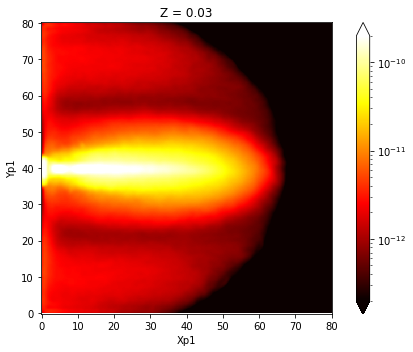

In [20]:
jacstd_sm = filter.apply(jacstd_padded.chunk({'Yp1':-1,'Xp1':-1}), dims=['Yp1','Xp1'])

fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
(jacstd_sm.isel(Z=0) * U**2/Rd**2).plot(cmap='hot', norm=clr.LogNorm(vmin=2e-13, vmax=2e-10))
ax.set_aspect('equal', adjustable='box')

In [25]:
nmask = 4
jacstd_sm.isel(Yp1=slice(1,-1),
               Xp1=slice(1,-1)).coarsen(Yp1=nmask, Xp1=nmask, 
                                        boundary='exact').mean().to_dataset(name='xi').to_netcdf(op.join(scratch,
                                                                                    'jacstd_N128-from-N512_nl3.nc'))

In [14]:
Anoise = 1.
nmask = 4

Nz, Ny, Nx = jacstd_sm.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coarsen(Yp1=nmask, Xp1=nmask, boundary='exact').mean().shape
std_bas = np.zeros((Nz,Ny+1,Nx+1))
std_bas[:,1:,1:] = jacstd_sm.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coarsen(Yp1=nmask, Xp1=nmask, boundary='exact').mean().data * Anoise
std_bas[:,0,0] = Ny
std_bas = np.transpose(std_bas, (0,2,1))
std_bas.astype('f4').tofile(scratch+'jacstd_N128-from-N512_nl3.bas')

In [15]:
Nz, Ny, Nx = dsbp.pb.coarsen(YC=nmask, XC=nmask, boundary='exact').mean().shape
pb_bas = np.zeros((Nz,Ny+1,Nx+1))
pb_bas[:,1:,1:] = dsbp.pb.coarsen(YC=nmask, XC=nmask, boundary='exact').mean().data
pb_bas[:,0,0] = Ny
pb_bas = np.transpose(pb_bas, (0,2,1))
pb_bas.astype('f4').tofile(scratch+'psib_N128-from-N512_nl3.bas')

In [11]:
client.close()